# mlarena Advanced Usage

This notebook demonstrates more advanced usage of the `mlarena` library for ML model optimization.

1. PreProcessing strategy analysis
2. Custom configure algorithms and preprocessing strategy
3. Bayesian Hyperparameter tuning
4. Threshold analysis for classification models

In [1]:
# Standard library imports
import multiprocessing
import os

# Third-party imports
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Local imports
from mlarena import ML_PIPELINE, PreProcessor
import mlflow
mlflow.autolog(disable=True)

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)


# 1. PreProcessing Strategy Analysis

In [2]:
# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(100, 10, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features with low cardinality
    'education': np.random.choice(['High School', 'Bachelor', 'Master or above'], n_samples),
    'occupation': np.random.choice(['Engineer'], n_samples), #only one value
    
    # Categorical features with higher cardinality
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*80 + ['D']*30 + ['E']*20 + ['F']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data              
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

## Filter Feature Selection

Run filter feature selection based on 
1. missing threshold
2. mutual information threshold
3. feature with only one single value will also be excluded

In [3]:
fitler_fs = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  mi_threshold = 0.05)

Filter Feature Selection Summary:
Total features analyzed: 7

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Low mutual information (<0.05): 3 columns
   Columns: age, tenure, occupation

Recommended drops: (3 columns in total)


In [4]:
# detailed results available as a dataframe
fitler_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
0,city,0.0200,5,0.00625,object,0.016899,1.000000,False,False,False
1,product,0.0000,6,0.00750,object,0.011228,0.664413,False,False,False
2,income,0.0000,800,1.00000,float64,0.001354,0.080128,False,False,False
3,education,0.0275,3,0.00375,object,0.000904,0.053503,False,False,False
4,age,0.0475,762,0.95250,float64,0.000000,0.000000,False,False,True
5,tenure,0.0000,13,0.01625,int32,0.000000,0.000000,False,False,True
6,occupation,0.0000,1,0.00125,object,0.000000,0.000000,False,True,True


In [5]:
selected_cols = fitler_fs['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income, education


## Recommend encoding candidates

The `identify_encoding_candidates` method recommend encoding based on:

1. High cardinality threshold
2. Rare category
3. User preference

In [6]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train[selected_cols], 
                                                                 high_cardinality_threshold=5)

-------------------------
Column `city` Analysis:
Recommend target encoding with higher smoothing due to moderate cardinality and rare category

column `city` details:
• Missing rate: 2.0%
• Unique values: 5
• Minimum category size: 24
• Rare categories: 2
-------------------------
Column `product` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `product` details:
• Missing rate: 0.0%
• Unique values: 6
• Minimum category size: 14
• Rare categories: 3
-------------------------
Column `education` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `education` details:
• Missing rate: 2.8%
• Unique values: 3
• Minimum category size: 247
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 3
• One-hot encoding cols: 0


In [7]:
# access the detailed analysis in dataframe form if preferred
encoding_recommendations['analysis']

,column,missing_rate,unique_values,min_category_size,rare_categories,encoding_note
0,city,0.0200,5,24,2,"Has 2 rare categories, careful for sparse feat..."
1,product,0.0000,6,14,3,Has 3 rare categories. Recommend higher smooth...
2,education,0.0275,3,247,0,Either encoding will do due to moderate cardin...


In [8]:
target_encode_cols = encoding_recommendations['target_encode_cols']
preprocessor = PreProcessor(
    target_encode_cols=target_encode_cols,
    target_encode_smooth='auto'
)
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_cols],y_train)
X_test_preprocessed =  preprocessor.transform(X_test[selected_cols])

## Compare Smoothing Strategies

Once the target encoding columns have been selected, the next decision we need to make is about the best smoothing strategies, which can be used to balance between the raw category means and the global mean to avoid overfitting. Two main smoothing strategies are available:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

As shown above, different smoothing strategies returns diffent result for a column of interests. The `plot_target_encoding_comparison` method visualizes how different smoothing parameters affect the encoded values. This is especially critical for categorical features with rare categories where overfitting is a bigger concern. Pls see below the visualization of `city`, where rare categories exist, and `education` with sufficiant sample sizes for each category. Smoothing parameters make a big difference for `city`, and in particular for the rare cagtegory Seattle whose train mean is much lower than the global mean. 

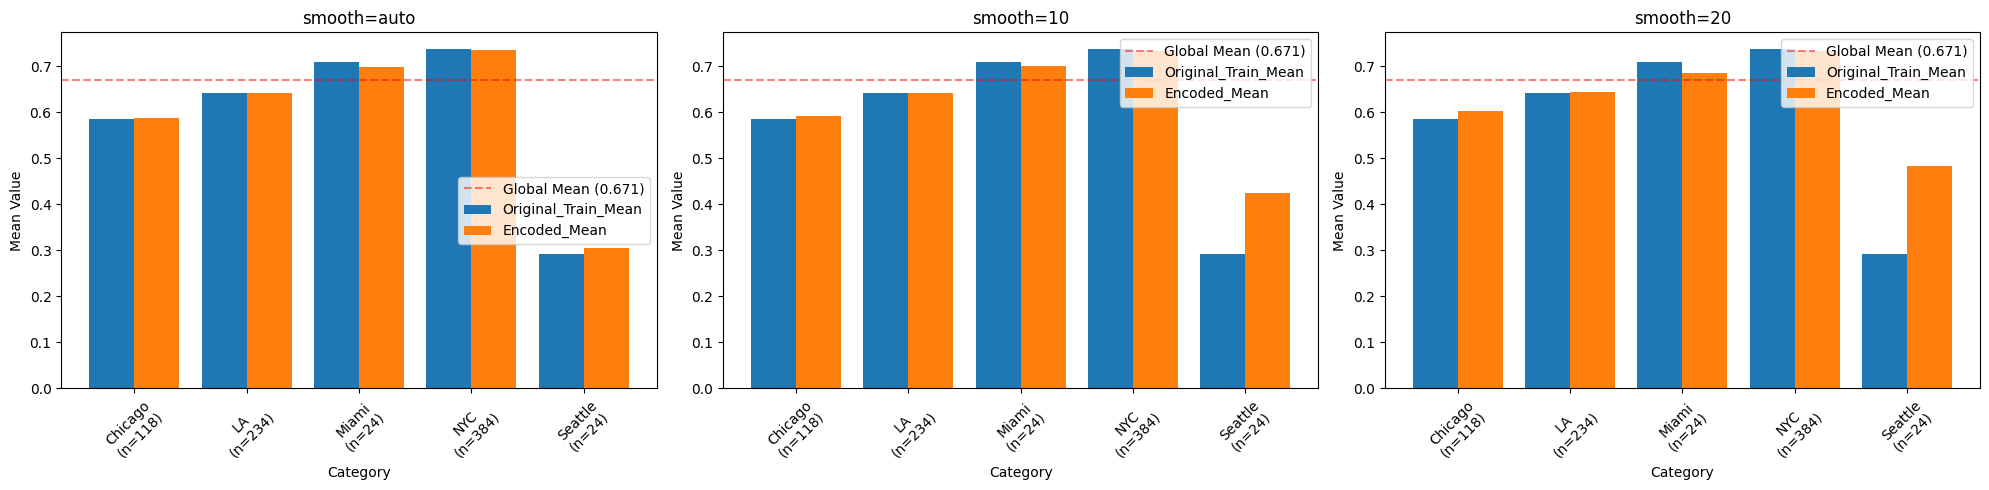

In [9]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

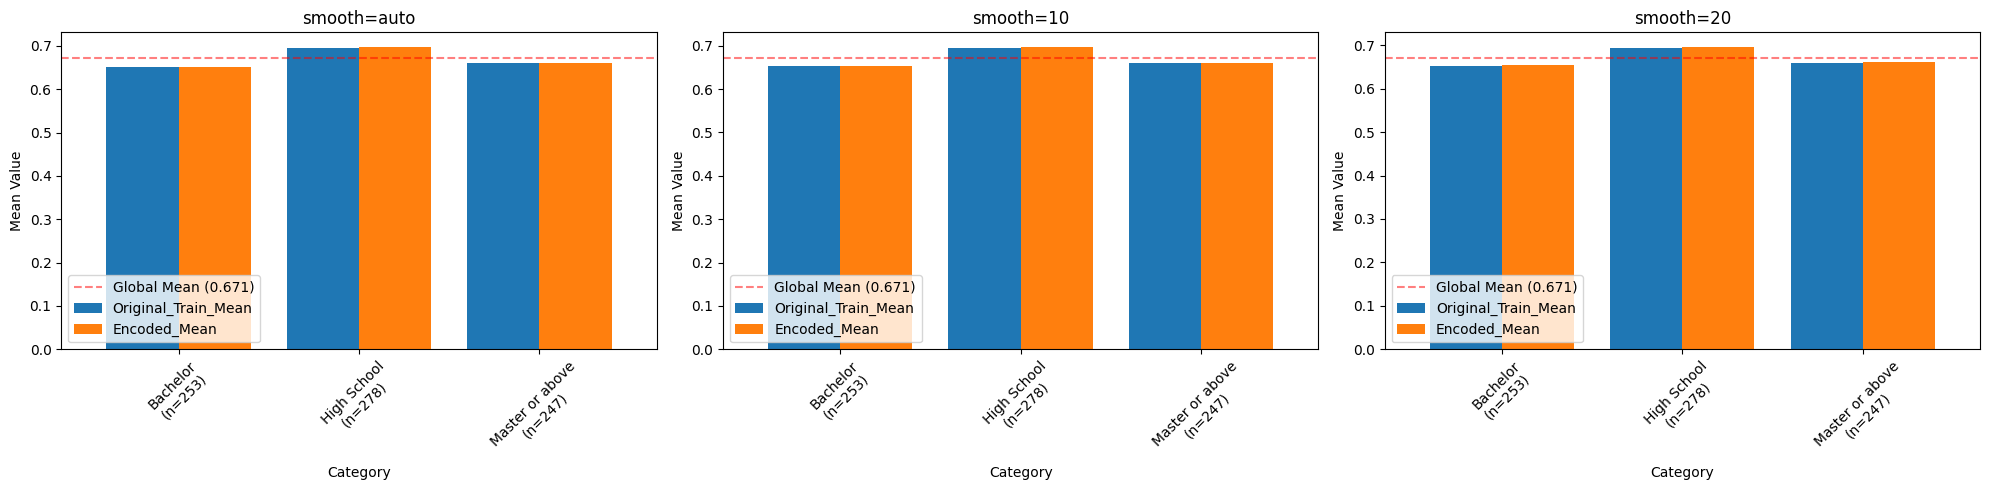

In [10]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'education',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

# 2. Custom Configure Algorithms and Preprocessing Strategy

In [11]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X = PreProcessor.mlflow_input_prep(X)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [12]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train)

-------------------------
Column `sex` Analysis:
Recommend one-hot encoding as the number of unique value is less or equal to 2

column `sex` details:
• Missing rate: 0.0%
• Unique values: 2
• Minimum category size: 278
• Rare categories: 0
-------------------------
Column `embarked` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `embarked` details:
• Missing rate: 0.1%
• Unique values: 3
• Minimum category size: 72
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 1


In [13]:
# custom configure the algorithm and preprocessor
lgb_params = {
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "scale_pos_weight": 1.9,
    "verbose": -1
}
ml_pipeline = ML_PIPELINE(
    model=lgb.LGBMClassifier(**lgb_params),
    preprocessor=PreProcessor(
        num_impute_strategy="mean",  # default "median"
        target_encode_cols=encoding_recommendations["target_encode_cols"],
    ),
)
ml_pipeline.fit(X_train, y_train)

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.790
F1:        0.744
Precision: 0.825
Recall:    0.678
Log Loss:  0.540
Pos Rate:  0.370

AUC (threshold independent):
AUC:   0.833


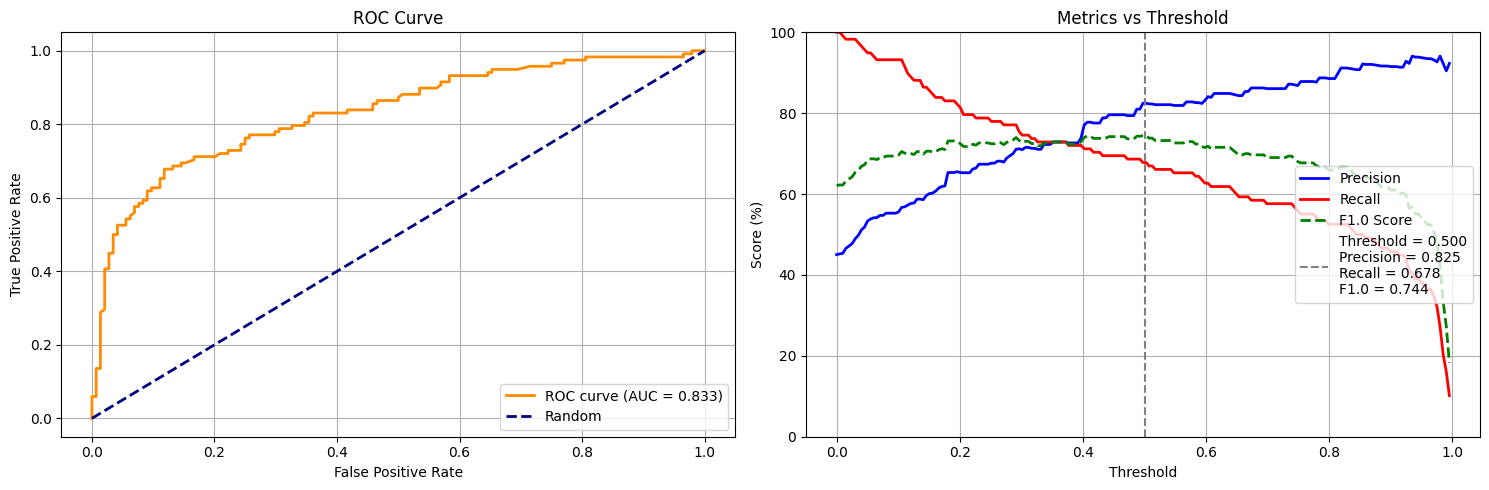

In [14]:
results = ml_pipeline.evaluate(X_test, y_test)

# 3. Bayesian Hyperparameter Tuning

Below is a summary of three main approaches for hyperparameter tuning. 


| Approach        | Search Strategy                           | Efficiency  | Strengths                                           | Weaknesses                                       | When to Use |
|---------------|----------------------------------|------------|------------------------------------------------|------------------------------------------------|--------------|
| **Grid Search** | Exhaustive search over a predefined grid | Low         | - Guarantees finding the best combination (if small search space)  | - Computationally expensive, scales poorly with dimensionality | Small, well-defined search spaces |
| **Random Search** | Samples hyperparameters randomly | Medium      | - More efficient than grid search, explores more diverse values | - Does not leverage past results for better sampling | Large search spaces, unknown parameter importance |
| **Bayesian Optimization (e.g., TPE in Hyperopt)** | Builds a probabilistic model to guide search | High        | - Learns from past evaluations, focuses on promising areas | - More complex to implement, can be slower in early iterations | Optimize search routes for expensive evaluations to achieve the best result effectively |


<br>



The advantage of the Bayesian method over grid and random search is that it intelligently guides the search for optimal hyperparameters by leveraging past evaluations, making it more efficient and effective, especially in large or complex search spaces. While the approach is admittedly more complex, `mlarena` offers a `tune` method that makes it more approachable and easier to implement. Its features include 

- Iterative tuning using Tree-structured Parzen Estimators (TPE) via hyperopt
- Implements k-fold cross-validation for robust evaluation
- Early stopping option to avoid overfitting and wasted computation
- Supports custom preprocessing pipelines
- Works well with any ML algorithm that follows sklearn API convensions
- Comprehensive reports with common metrics and plots
- Parallel coordinates plot for diagnosis of the search space


### 3.1 Set the search space and tune

In [15]:
# Define the hyperparameter search ranges
lgb_param_ranges = {
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (100, 1000),   
    'num_leaves': (20, 100),
    'max_depth': (5, 15),
    'colsample_bytree': (0.6, 1.0),
    'subsample': (0.6, 0.9)
}

Best CV AUC: 0.858(0.032)

Performance on holdout validation set:
Classification Metrics Report

Evaluation Parameters:
Threshold: 0.337
Beta:      1.000

Metrics:
Accuracy:  0.786
F1:        0.762
Precision: 0.758
Recall:    0.766
Log Loss:  0.477
Pos Rate:  0.452

AUC (threshold independent):
AUC:   0.855


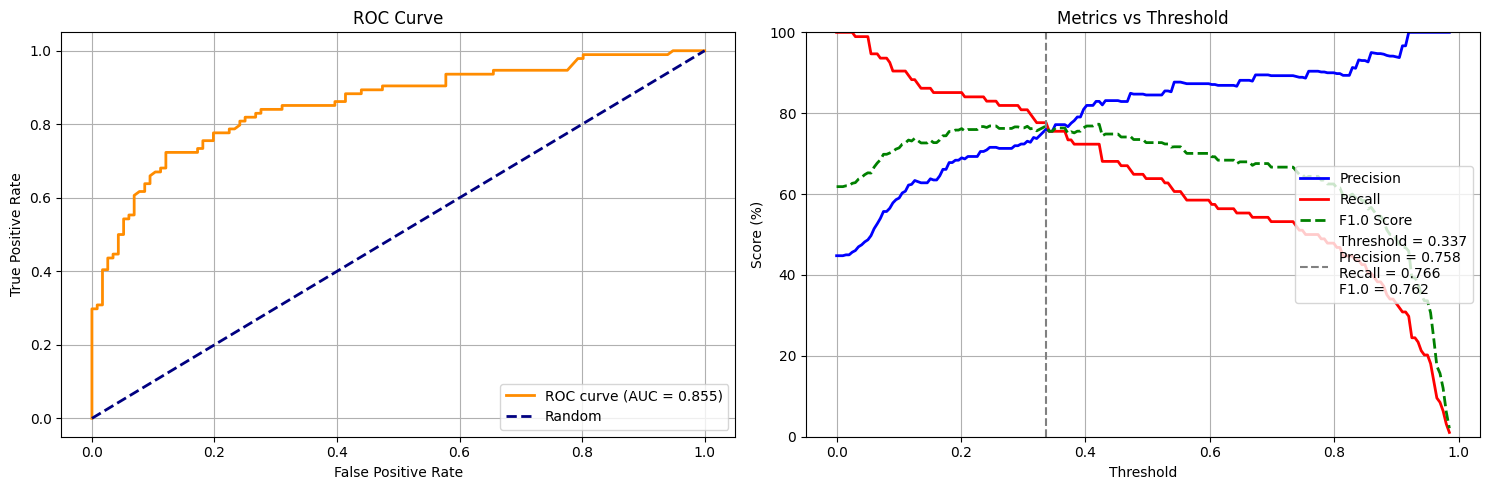


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.04102561463255635
n_estimators: 128
num_leaves: 27
max_depth: 14
colsample_bytree: 0.636210786524511
subsample: 0.8409474137439417
Logging the best model to MLflow


2025/05/07 00:03:41 INFO mlflow.pyfunc: Validating input example against model signature



Hyperparameter Parallel Coordinate Plot:


In [16]:
best_lgb = ML_PIPELINE.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=500,
                          patience=50,  
                          n_startup_trials=50,
                          verbose=-1,
                          cv=5,
                          cv_variance_penalty=0.3,
                          log_best_model=True)

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.337
Beta:      1.000

Metrics:
Accuracy:  0.782
F1:        0.747
Precision: 0.785
Recall:    0.712
Log Loss:  0.485
Pos Rate:  0.408

AUC (threshold independent):
AUC:   0.859


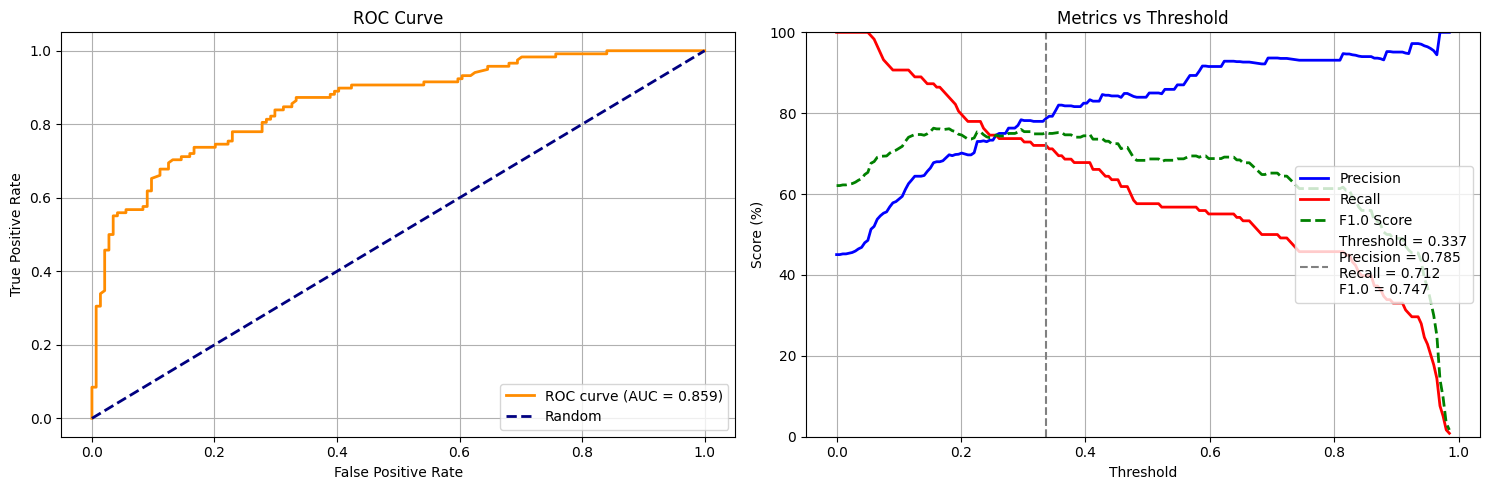

In [17]:
# extract the best model, evaluate with new data and understand its reasoning
best_pipeline = best_lgb['best_pipeline']
beta = best_lgb['beta']
optimal_threshold = best_lgb['optimal_threshold']
metrics = best_pipeline.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)

## 3.2 Retrive the best model logged with Mlflow

In [18]:
model_info = best_lgb["model_info"]
print(model_info.utc_time_created)
print(model_info.run_id)
print(model_info.model_uri)
print(model_info.mlflow_version)

2025-05-06 14:03:41.611236
c143a9e57c694b969de713be7b378a34
runs:/c143a9e57c694b969de713be7b378a34/ml_pipeline
2.22.0


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.337
Beta:      1.000

Metrics:
Accuracy:  0.782
F1:        0.747
Precision: 0.785
Recall:    0.712
Log Loss:  0.485
Pos Rate:  0.408

AUC (threshold independent):
AUC:   0.859


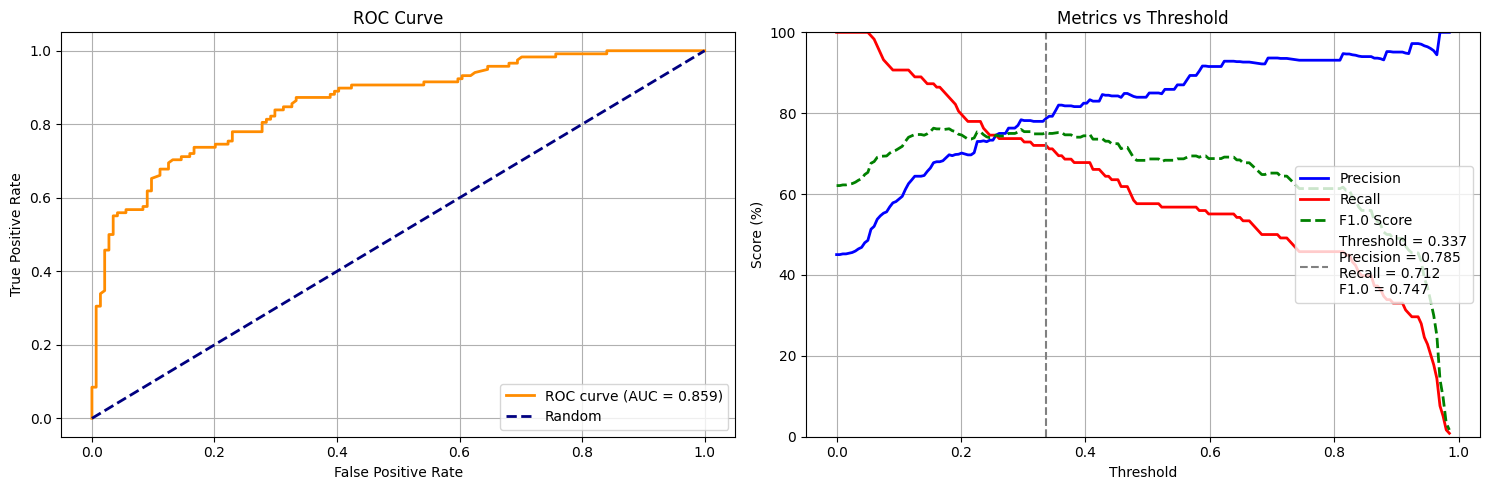

In [19]:
# loaded model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
# full function of the ML_PIPELINE instance
unwrapped_model = loaded_model.unwrap_python_model()
run_id = loaded_model.metadata.run_id
run = mlflow.get_run(run_id)
beta = run.data.metrics['beta']
threshold = run.data.metrics['threshold']
results = unwrapped_model.evaluate(X_test, y_test, beta=beta, threshold=threshold)

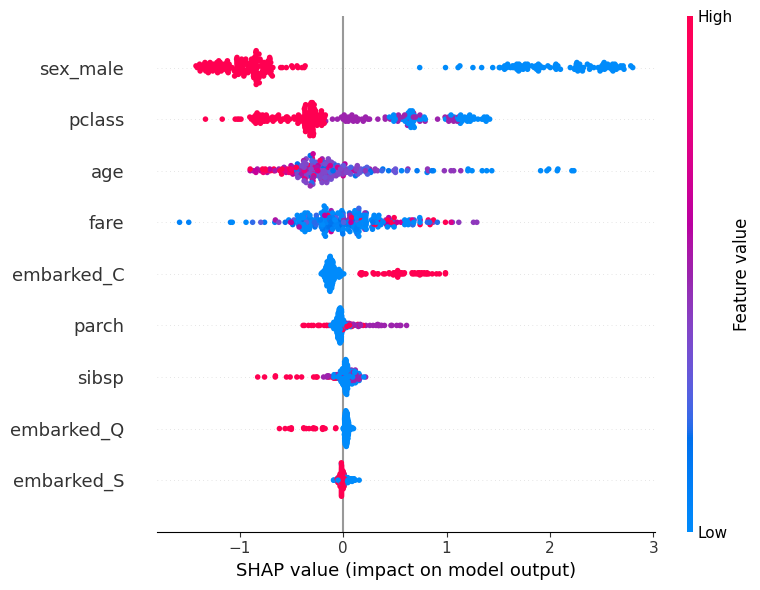

In [20]:
unwrapped_model.explain_model(X_test)

In [21]:
# prediction with loaded model directly
X_test_prepped = PreProcessor.mlflow_input_prep(X_test)
loaded_model.predict(pd.DataFrame(X_test_prepped.head()))

array([0.04111366, 0.47827632, 0.0525564 , 0.06316844, 0.05470437])

## 3.3 Quick Demo for Alternative Metrics

The metrics the `tune` method can optimize include
- Classification tasks:
    - auc (default)
    - f1
    - accuracy
- Regression tasks:
    - rmse (default)
    - nrmse
    - mape  

Best CV F1: 0.713(0.048)

Performance on holdout validation set:
Classification Metrics Report

Evaluation Parameters:
Threshold: 0.429
Beta:      1.000

Metrics:
Accuracy:  0.781
F1:        0.733
Precision: 0.808
Recall:    0.670
Log Loss:  0.478
Pos Rate:  0.371

AUC (threshold independent):
AUC:   0.853


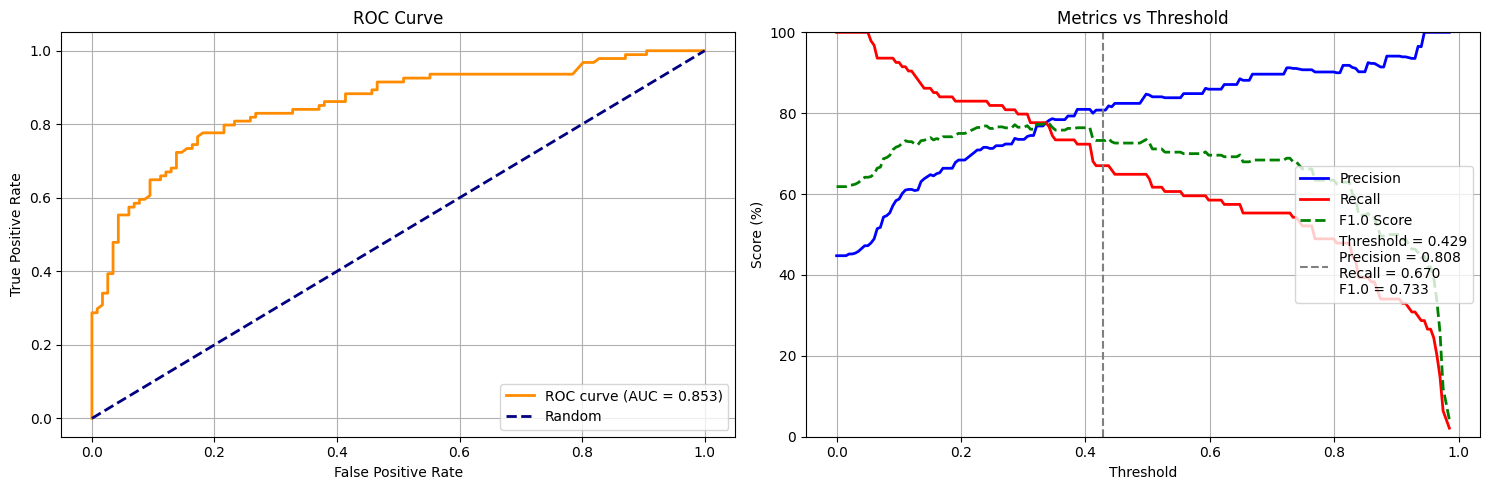


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.01390971612710784
n_estimators: 338
num_leaves: 73
max_depth: 8
colsample_bytree: 0.8426950989335374
subsample: 0.8370704444131476

Hyperparameter Parallel Coordinate Plot:


In [22]:
best_lgb_f1 = ML_PIPELINE.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          tune_metric='f1',
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=100,
                          patience=10,  
                          n_startup_trials=10,
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.3,
                          log_best_model=False)

Best CV LOG_LOSS: 0.432(0.032)

Performance on holdout validation set:
Classification Metrics Report

Evaluation Parameters:
Threshold: 0.440
Beta:      1.000

Metrics:
Accuracy:  0.781
F1:        0.733
Precision: 0.808
Recall:    0.670
Log Loss:  0.473
Pos Rate:  0.371

AUC (threshold independent):
AUC:   0.855


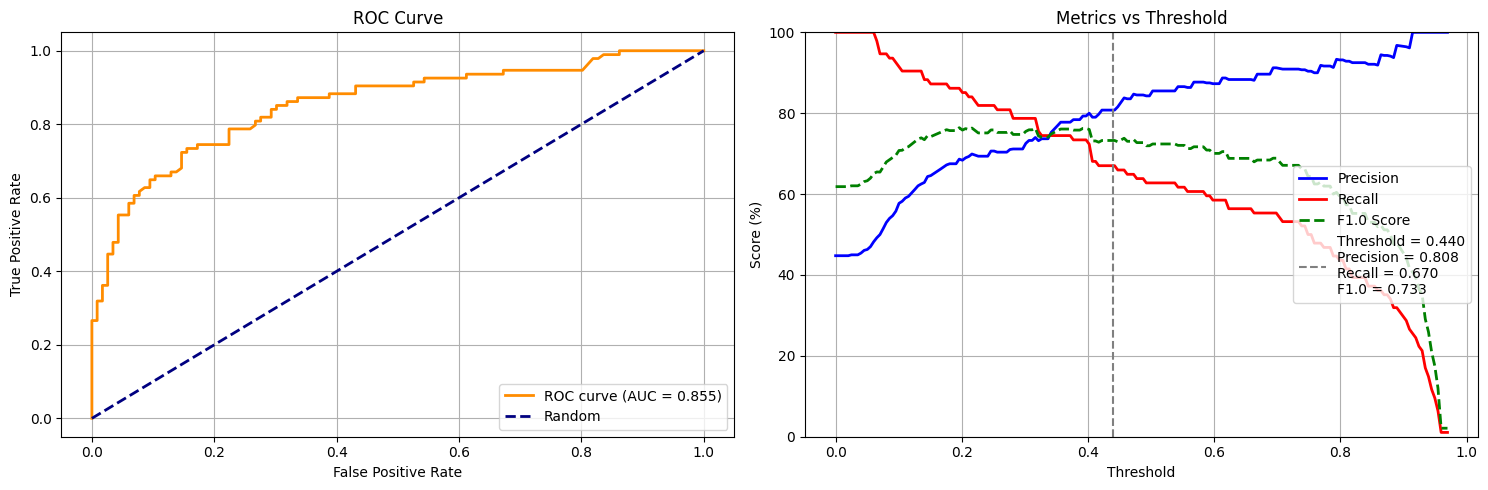


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.023224999802520803
n_estimators: 143
num_leaves: 76
max_depth: 14
colsample_bytree: 0.7798524710187904
subsample: 0.6695319392781165

Hyperparameter Parallel Coordinate Plot:


In [23]:
best_lgb_log_loss = ML_PIPELINE.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          tune_metric='log_loss',
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=100,
                          patience=10,  
                          n_startup_trials=10,
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.3,
                          log_best_model=False)

## 3.4 Quick Demo for Regressor Tuning

Best CV SMAPE: 15.378(0.128)

Performance on holdout validation set:
Regression Model Evaluation:
RMSE: 0.462
MAE: 0.303
Median AE: 0.195
R² Score: 0.845
Adjusted R² Score: 0.845

Normalized RMSE Variants:
- NRMSE (mean): 22.1%
- NRMSE (std): 39.3%
- NRMSE (IQR): 31.4%

Percentage Errors:
- MAPE: 16.7% (excluding zeros)
- SMAPE: 15.3%

RMSE Improvements over Baselines:
- vs Mean: 60.7%
- vs Median: 61.7%


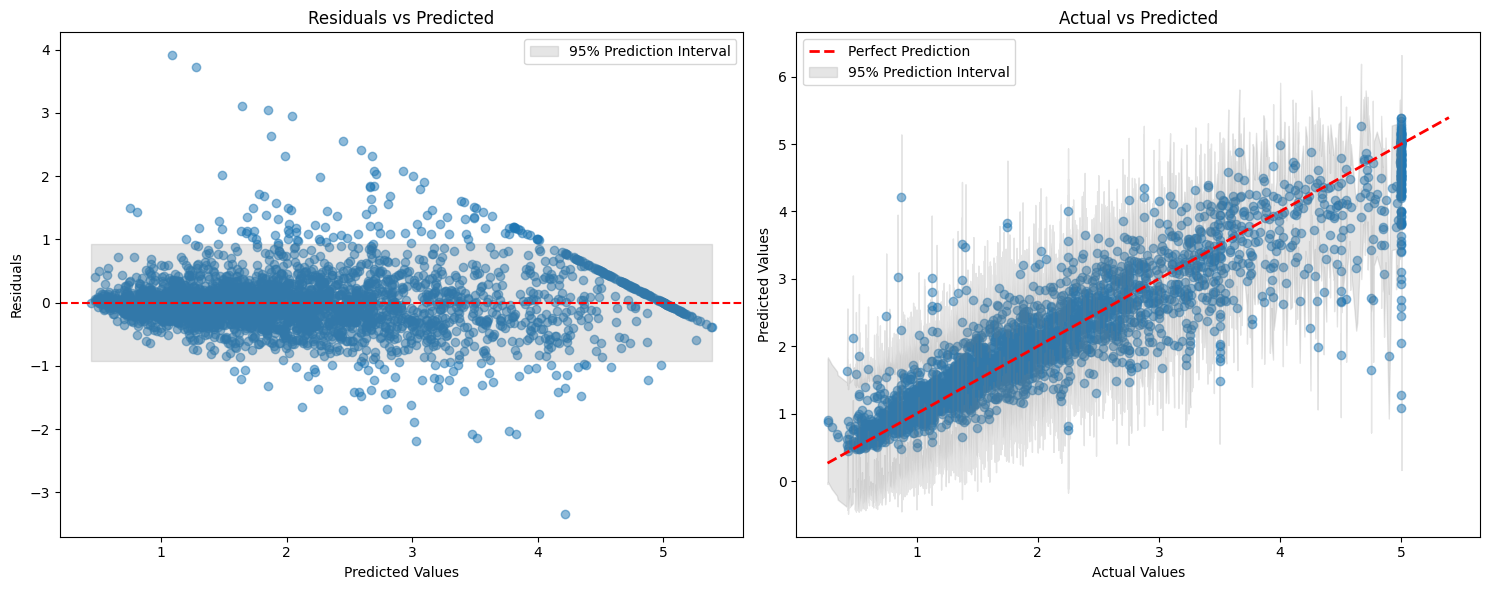


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.05256638239567716
n_estimators: 439
num_leaves: 50
max_depth: 10
colsample_bytree: 0.7447639276510406
subsample: 0.5470850080260985

Hyperparameter Parallel Coordinate Plot:


In [31]:
from sklearn.datasets import (
    fetch_california_housing
)
california = fetch_california_housing()
X_housing = pd.DataFrame(california.data, columns=california.feature_names)
X_housing = PreProcessor.mlflow_input_prep(X_housing)

y_housing = california.target
X_train_full_housing, X_test_housing, y_train_full_housing, y_test_housing = train_test_split(X_housing, y_housing, test_size=0.2, random_state=42)
# Define the hyperparameter search ranges
lgb_param_ranges = {
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (100, 500),   
    'num_leaves': (10, 50),
    'max_depth': (5, 15),
    'colsample_bytree': (0.5, 0.9),
    'subsample': (0.5, 0.9)
}
# tune the regressor
best_lgb_rgs = ML_PIPELINE.tune(X_train_full_housing, y_train_full_housing, 
                          algorithm=lgb.LGBMRegressor, 
                          preprocessor=PreProcessor(),
                          param_ranges=lgb_param_ranges,  
                          # tune_metric= "smape",
                          max_evals=100,
                          patience=10,  
                          n_startup_trials=10,
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.1,
                          log_best_model=False)

# 4. Threshold Analysis for Classification Models

In classification problems, there's an inherent trade-off between precision and recall. Different business scenarios may require different balances - fraud detection might prioritize precision to avoid false accusations, while medical screening might favor recall to catch all potential cases.

`mlarena` offers a `threshold_analysis` method that:
- Finds the optimal classification threshold based on your business needs 🎯
- Customizes precision-recall trade-offs through the beta parameter in F-beta score:
  - (1+β²)·(precision·recall)/(β²·precision+recall), specifically
  - When beta < 1: Precision is weighted more heavily
  - When beta = 1: Precision and recall are weighted equally (F1 score)
  - When beta > 1: Recall is weighted more heavily
- Implements stratified k-fold cross-validation for robust results

### 4.1 Threshold optimization in action

The demo below shows threshold optimization in action 🎯
1. Take a trained ML_PIPELINE instance
    * which could be a best model from `tune` 
    * or a baseline model trained based on default config (see [1.basic_usage.ipynb](https://github.com/MenaWANG/mlarena/blob/master/examples/1.basic_usage.ipynb))
2. Use the train data to tune the optimal threshold using two methods:
    * Cross-validation method: splits data into folds to find robust threshold
    * Bootstrap method: resamples data with replacement for confidence intervals
    * Both methods allow setting beta parameter to balance precision vs recall
3. Compare results from both methods and their statistics
4. Apply the optimized thresholds to new data and evaluate performance

In [25]:
# take the best model identified, and identify the optimal threshold F0.8, which gives precision double the weight as recall
y_pred_proba = best_pipeline.predict(context=None, model_input = X_train_full)
results_cv = ML_PIPELINE.threshold_analysis(y_train_full, y_pred_proba, beta = 0.8, cv_splits=3)
results_boot = ML_PIPELINE.threshold_analysis(y_train_full, y_pred_proba, beta = 0.8, method = "bootstrap", bootstrap_iterations=100)
print(f"The optimizal threshold to maximize F0.8 from two methods respectively are CV: {results_cv['optimal_threshold']:.3f}, bootstrap: {results_boot['optimal_threshold']:.3f} ")


The optimizal threshold to maximize F0.8 from two methods respectively are CV: 0.492, bootstrap: 0.469 


In [26]:
# Detailed threshold statistics for both methods
print("\nCross-Validation Method Results:")
print(f"Optimal Threshold: {results_cv['optimal_threshold']:.4f}")
print(f"Threshold Std Dev: {results_cv['threshold_std']:.4f}")

print("\nBootstrap Method Results:")
print(f"Optimal Threshold: {results_boot['optimal_threshold']:.4f}")
print(f"Threshold Std Dev: {results_boot['threshold_std']:.4f}")
print(f"95% CI Lower: {results_boot['ci_lower']:.4f}")
print(f"95% CI Upper: {results_boot['ci_upper']:.4f}")


Cross-Validation Method Results:
Optimal Threshold: 0.4917
Threshold Std Dev: 0.0525

Bootstrap Method Results:
Optimal Threshold: 0.4688
Threshold Std Dev: 0.0451
95% CI Lower: 0.4087
95% CI Upper: 0.5500


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.492
Beta:      0.800

Metrics:
Accuracy:  0.760
F1:        0.683
F_beta:    0.712
Precision: 0.840
Recall:    0.576
Log Loss:  0.485
Pos Rate:  0.309

AUC (threshold independent):
AUC:   0.859


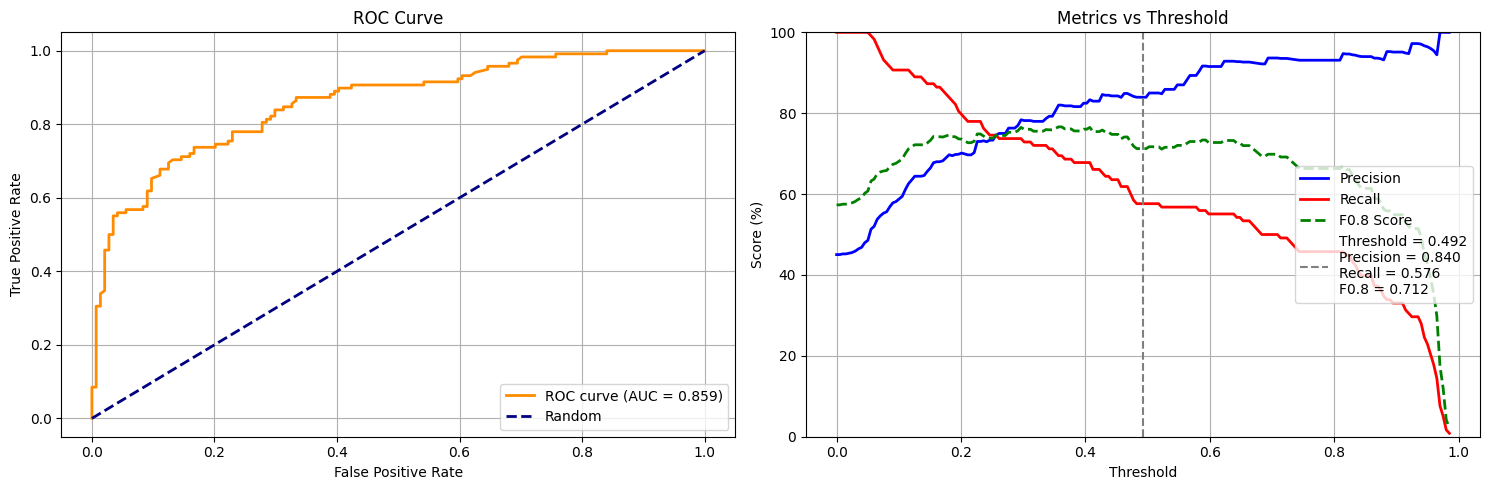

In [27]:
# Utimize the threshold on new data 
performance_cv = best_pipeline.evaluate(X_test, y_test, beta=0.8, threshold=results_cv['optimal_threshold'])

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.469
Beta:      0.800

Metrics:
Accuracy:  0.775
F1:        0.709
F_beta:    0.736
Precision: 0.847
Recall:    0.610
Log Loss:  0.485
Pos Rate:  0.324

AUC (threshold independent):
AUC:   0.859


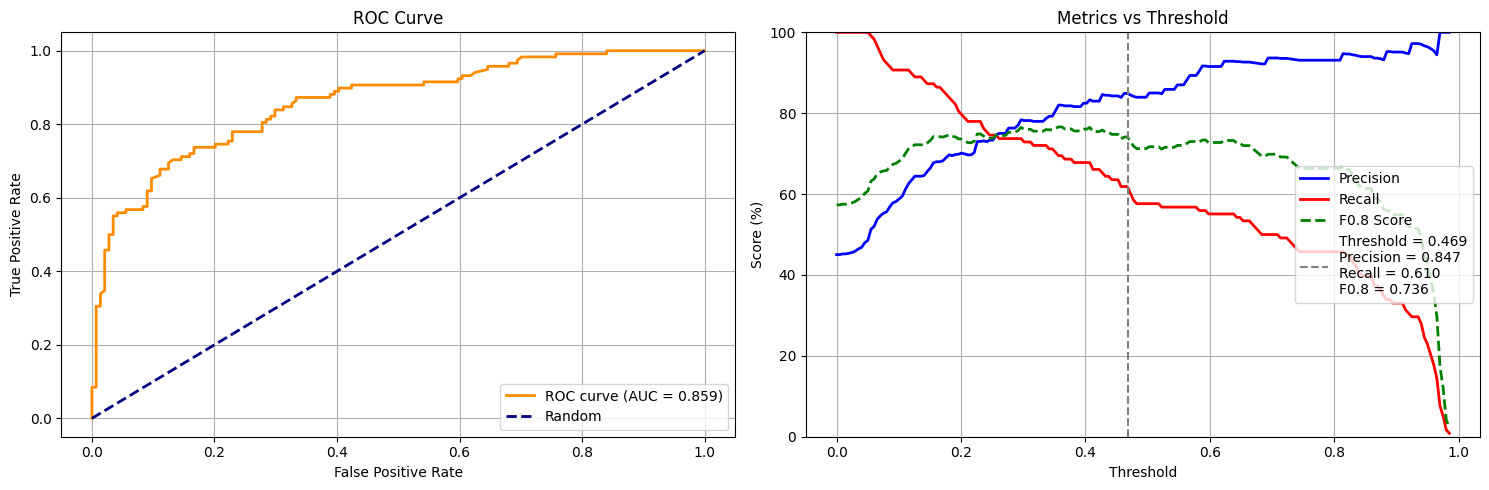

In [28]:
performance_boot = best_pipeline.evaluate(X_test, y_test, beta=0.8, threshold=results_boot['optimal_threshold'])

### 4.2 Log and utilize the logged model

In [29]:
# log a model using the _log_model method directly
model_info = best_pipeline._log_model(
    metrics = performance_boot,
    params = best_pipeline.model.get_params(),
    sample_input=X_test.iloc[:1],
    sample_output=y_pred_proba[:1]
)

2025/05/07 00:07:02 INFO mlflow.pyfunc: Validating input example against model signature


Classification Metrics Report

Evaluation Parameters:
Threshold: 0.469
Beta:      0.800

Metrics:
Accuracy:  0.775
F1:        0.709
F_beta:    0.736
Precision: 0.847
Recall:    0.610
Log Loss:  0.485
Pos Rate:  0.324

AUC (threshold independent):
AUC:   0.859


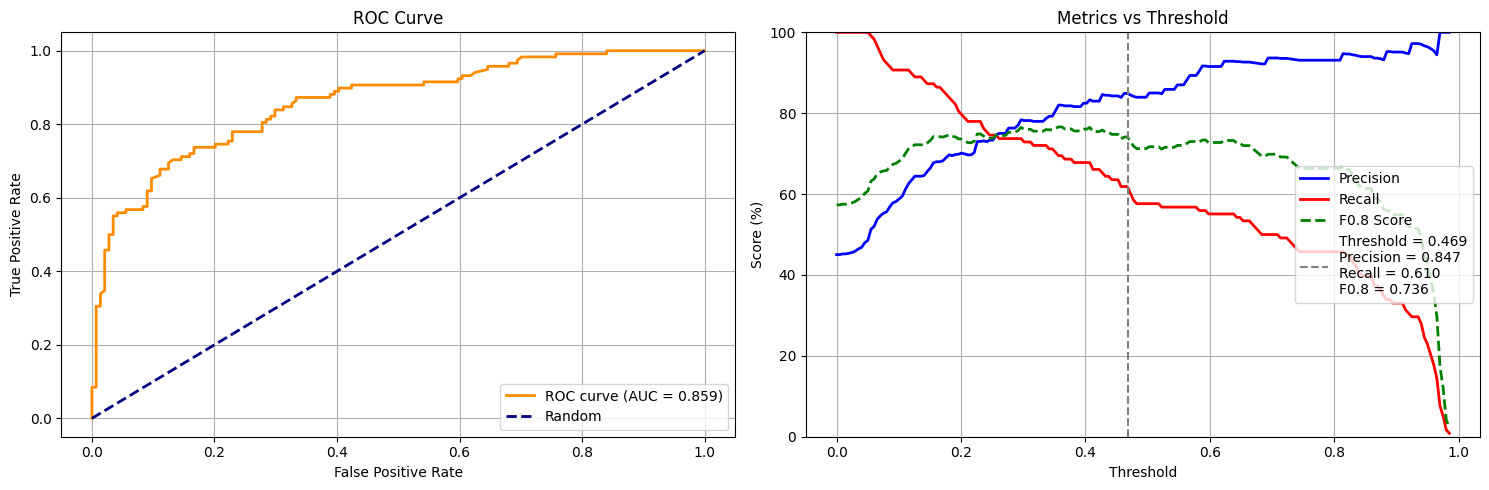

In [30]:
# load and utilize the logged model
loaded_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri) 
unwrapped_model = loaded_model.unwrap_python_model()
run = mlflow.get_run(model_info.run_id)
beta = run.data.metrics['beta']
threshold = run.data.metrics['threshold']
results = unwrapped_model.evaluate(X_test, y_test, beta=beta, threshold=threshold)